In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = image_dataset_from_directory(
   "../input/potato-disease/Potato/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2022-05-21 16:35:57.156215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 16:35:57.271603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 16:35:57.272351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 16:35:57.281403: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

2022-05-21 16:35:59.917985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


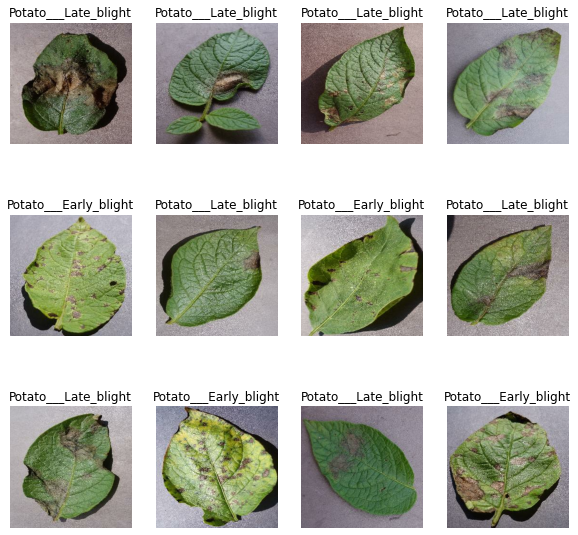

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
def get_dataset_partitions(dataset, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size).skip(val_size)

    return train_data, val_data, test_data

In [7]:
 train_data, val_data, test_data = get_dataset_partitions(dataset)

In [8]:
len(train_data),len(val_data),len(test_data)

(54, 6, 8)

In [9]:
# Optimization for training performance
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/ 255)    
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)    
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_class = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_class, activation='softmax')

])

model.build(input_shape = input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [14]:
model.compile(
optimizer = "adam",
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics = ["accuracy"]
)

In [15]:
history = model.fit(train_data, 
          epochs = EPOCHS, 
          batch_size = BATCH_SIZE,
          verbose = 2, 
          validation_data = val_data
         )

Epoch 1/50


2022-05-21 16:36:10.105941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 - 18s - loss: 0.9148 - accuracy: 0.5018 - val_loss: 0.8547 - val_accuracy: 0.6250
Epoch 2/50
54/54 - 2s - loss: 0.8168 - accuracy: 0.6209 - val_loss: 0.8693 - val_accuracy: 0.5573
Epoch 3/50
54/54 - 2s - loss: 0.5286 - accuracy: 0.7858 - val_loss: 0.4590 - val_accuracy: 0.8021
Epoch 4/50
54/54 - 2s - loss: 0.3610 - accuracy: 0.8474 - val_loss: 0.3659 - val_accuracy: 0.8490
Epoch 5/50
54/54 - 2s - loss: 0.2854 - accuracy: 0.8873 - val_loss: 0.6981 - val_accuracy: 0.7448
Epoch 6/50
54/54 - 2s - loss: 0.2438 - accuracy: 0.9073 - val_loss: 0.1554 - val_accuracy: 0.9323
Epoch 7/50
54/54 - 2s - loss: 0.1916 - accuracy: 0.9255 - val_loss: 0.3684 - val_accuracy: 0.8698
Epoch 8/50
54/54 - 2s - loss: 0.1881 - accuracy: 0.9319 - val_loss: 0.1171 - val_accuracy: 0.9531
Epoch 9/50
54/54 - 2s - loss: 0.1556 - accuracy: 0.9419 - val_loss: 0.1559 - val_accuracy: 0.9479
Epoch 10/50
54/54 - 2s - loss: 0.1363 - accuracy: 0.9442 - val_loss: 0.2889 - val_accuracy: 0.8698
Epoch 11/50
54/54 - 2s - loss

In [16]:
scores = model.evaluate(test_data)

8/8 [==============================] - 3s 14ms/step - loss: 0.0969 - accuracy: 0.9727


In [17]:
scores

[0.09694989770650864, 0.97265625]

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

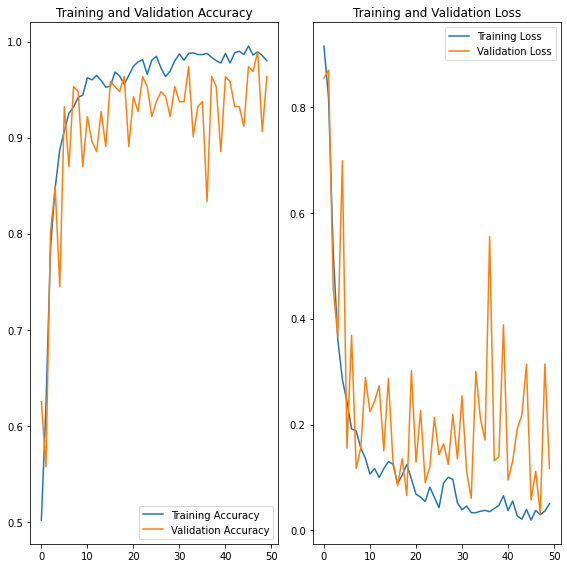

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()

First image for prediction

Actual label: Potato___Late_blight
Predicted label: Potato___Late_blight


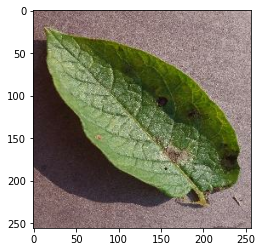

In [20]:
for image_batch, labels_batch in test_data.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("First image for prediction")
    plt.imshow(first_image)
    print()
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

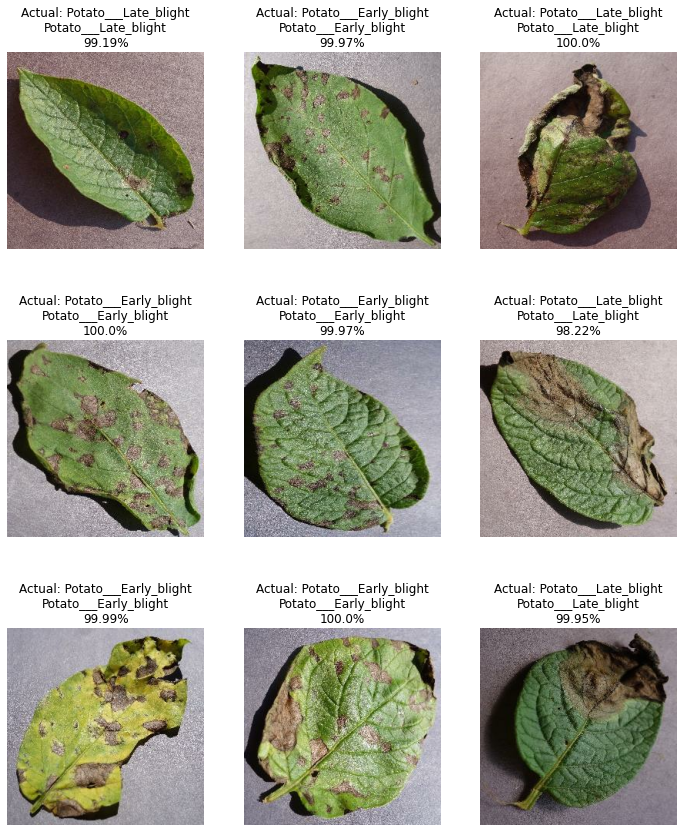

In [22]:
plt.figure(figsize=(12, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}\n{predicted_class}\n{confidence}%")
        plt.axis("off")

In [23]:
os.makedirs("./models", exist_ok=True)
model_version = len([os.listdir("./models")])
model.save(f"./models/{model_version}")

2022-05-21 16:38:14.429465: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
